In [1]:
#importing necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')


#importing libraries for machine learning
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import cv2 as cv
from tensorflow.keras.optimizers import Adam
from keras import optimizers
from keras.models import Sequential
from keras.regularizers import l2
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization

## Implementing Convolutional Neural Network

In [16]:
if USE_LESS_DATA:
    df_train = df_train[:5000]
    df_val = df_val[:1000]

In [17]:
#Applying Crop preprocess
X_train = df_train['image_paths'].apply(read_and_crop_image).values
X_val = df_val['image_paths'].apply(read_and_crop_image).values

y_train = df_train['image_labels'].values
y_val = df_val['image_labels'].values

X_train = np.stack(X_train, axis=0)
X_val = np.stack(X_val, axis=0)

#Expand dim to add channel info if image has 1 channel(Colorless)
if not KEEP_COLOR:
    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)

# Delete non used variables
del(df_train)
del(df_val)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state = MAIN_SEED)

print("X_train ->",X_train.shape,
      "\ny_train ->",y_train.shape,
      "\n\nX_test ->",X_test.shape,
      "\ny_test ->",y_test.shape,
      "\n\nX_val ->",X_val.shape,
      "\ny_val ->",y_val.shape
)

X_train -> (4500, 200, 200, 1) 
y_train -> (4500,) 

X_test -> (500, 200, 200, 1) 
y_test -> (500,) 

X_val -> (1000, 200, 200, 1) 
y_val -> (1000,)


## Preparing Bare CNN with Keras

#### Normalize Data

* Standart 8 bit color means pixels has values from 0 to 255.
* So we use min-max normalizer to normalize our features(pixels) from 0 to 1.

In [19]:
X_train = X_train / 255.0
X_val = X_val / 255.0

In [20]:
# We set input_shape
if len(X_train.shape) > 3:
    input_shape = X_train.shape[1:]
else:
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
input_shape

(200, 200, 1)

In [21]:
first_model = Sequential()
first_model.add(Conv2D(filters = 2, kernel_size = (3,3),padding = 'same',activation ='relu', input_shape = input_shape))
first_model.add(Conv2D(filters = 4, kernel_size = (3,3),padding = 'same',activation ='relu'))
first_model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'same',activation ='relu'))
first_model.add(MaxPool2D(pool_size=(2,2)))
first_model.add(Dropout(0.5))
first_model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'same',activation ='relu'))
first_model.add(MaxPool2D(pool_size=(2,2)))
first_model.add(Conv2D(filters = 24, kernel_size = (7,7),padding = 'same',activation ='relu'))
first_model.add(Dropout(0.5))
first_model.add(Flatten())
first_model.add(Dense(64, kernel_regularizer=l2(1e-5), activation = "relu"))
first_model.add(BatchNormalization())
first_model.add(Dense(32, kernel_regularizer=l2(1e-5), activation = "relu"))
first_model.add(Dense(32, kernel_regularizer=l2(1e-5), activation = "relu"))
first_model.add(Dense(1, activation = "sigmoid"))

* This is our first model summary for first aproach

In [22]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 2)       20        
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 4)       76        
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 200, 8)       808       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 100, 8)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 16)      3216      
                                                        

* Train model

In [23]:
optimizer = Adam(lr = LR)
first_model.compile(optimizer = optimizer,loss = 'binary_crossentropy',metrics = ['accuracy'])

first_model_trained = first_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs = EPOCH, validation_data = (X_val, y_val))

Epoch 1/50
141/141 [==============================] - 47s 325ms/step - loss: 0.6655 - accuracy: 0.6840 - val_loss: 1.1865 - val_accuracy: 0.6620
Epoch 2/50
141/141 [==============================] - 46s 324ms/step - loss: 0.6376 - accuracy: 0.7047 - val_loss: 0.8475 - val_accuracy: 0.5160
Epoch 3/50
141/141 [==============================] - 47s 330ms/step - loss: 0.6264 - accuracy: 0.7213 - val_loss: 0.9616 - val_accuracy: 0.6610
Epoch 4/50
141/141 [==============================] - 45s 320ms/step - loss: 0.6378 - accuracy: 0.7129 - val_loss: 0.7684 - val_accuracy: 0.6250
Epoch 5/50
141/141 [==============================] - 45s 322ms/step - loss: 0.6219 - accuracy: 0.7262 - val_loss: 0.7694 - val_accuracy: 0.6070
Epoch 6/50
141/141 [==============================] - 45s 317ms/step - loss: 0.6203 - accuracy: 0.7204 - val_loss: 0.7623 - val_accuracy: 0.5680
Epoch 7/50
141/141 [==============================] - 45s 322ms/step - loss: 0.6118 - accuracy: 0.7307 - val_loss: 0.7813 - val_ac

* Lets print the loss and acc graphs

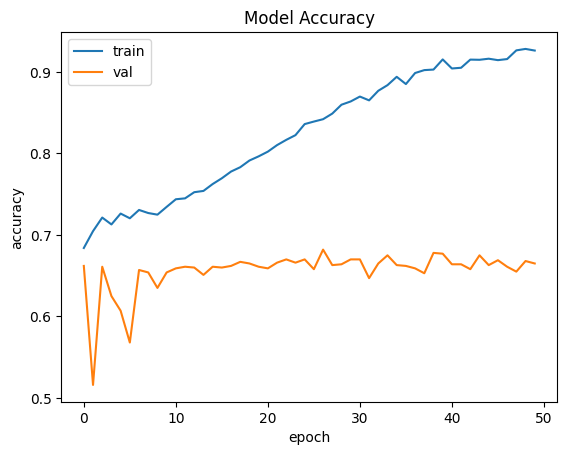

In [24]:
plt.plot(first_model_trained.history['accuracy'])
plt.plot(first_model_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

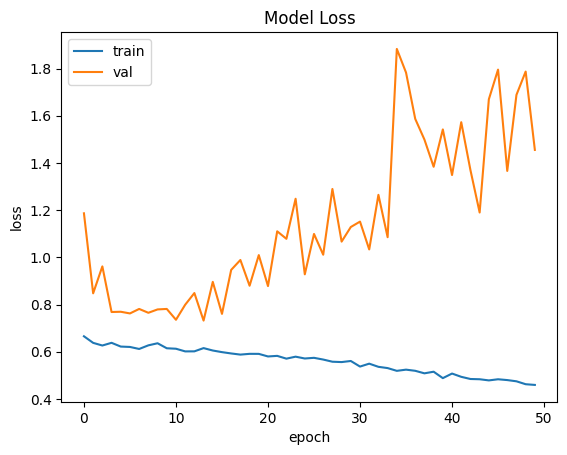

In [25]:
plt.plot(first_model_trained.history['loss'])
plt.plot(first_model_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
# Reshape the input data to match the model's input shape
X_test_reshaped = X_test.reshape(-1, 200, 200, 1)

In [27]:
predicted = first_model.predict(X_test_reshaped)

16/16 [==============================] - 1s 34ms/step


In [28]:
# Assuming the provided array is named 'predictions'
threshold = 0.5  # Adjust the threshold as needed

# Convert continuous values to binary
binary_predictions = np.where(predicted > threshold, 1, 0)

# Now you can evaluate the binary predictions using classification metrics
# For example, if you have the true labels stored in 'true_labels', you can calculate accuracy as follows:


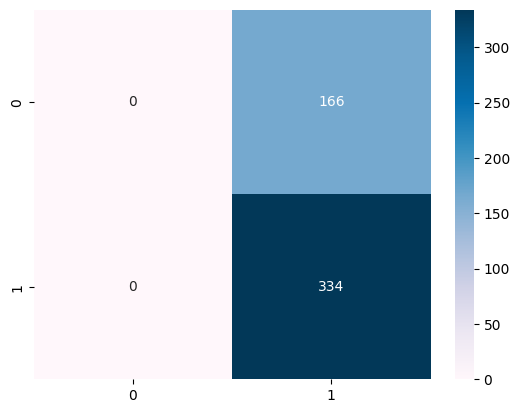

In [30]:
cf_matrix = confusion_matrix(y_test, binary_predictions)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()

In [31]:
print(classification_report(y_test, binary_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       166
           1       0.67      1.00      0.80       334

    accuracy                           0.67       500
   macro avg       0.33      0.50      0.40       500
weighted avg       0.45      0.67      0.54       500

